# Community detection

In this notebook we are going to detect some communities.

In [159]:
import os
import sys
import json

import numpy as np
import pandas as pd
import scipy.stats as sps
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm

sns.set(font_scale=1.3)

In [160]:
DATA_PREFIX = os.path.join(os.pardir, 'data')
FIGURES_PREFIX = os.path.join(os.pardir, 'figures')

In [161]:
g = nx.read_gml(os.path.join(DATA_PREFIX, 'graph.gml'))

connected_components = list(nx.connected_components(g))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
g_sub = g.subgraph(biggest_cc)

## Clique search 

Here we are going to detect some cliques and interpret them.

In [162]:
def largest_cliques(G):
    cmap = plt.cm.rainbow
    cliques = [i for i in nx.find_cliques(G)]
    max_size = len(max(cliques, key=len))
    colors = []
    i = 0
    for c in cliques:
        if len(c) == max_size:
            c_colors = []
            for node in G.nodes:
                c_colors.append(cmap(i*0.5)[:3] if node in c else (1, 1, 1))
            i += 1
            colors.append(c_colors)
    return np.array(colors)

In [163]:
colors = largest_cliques(g)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

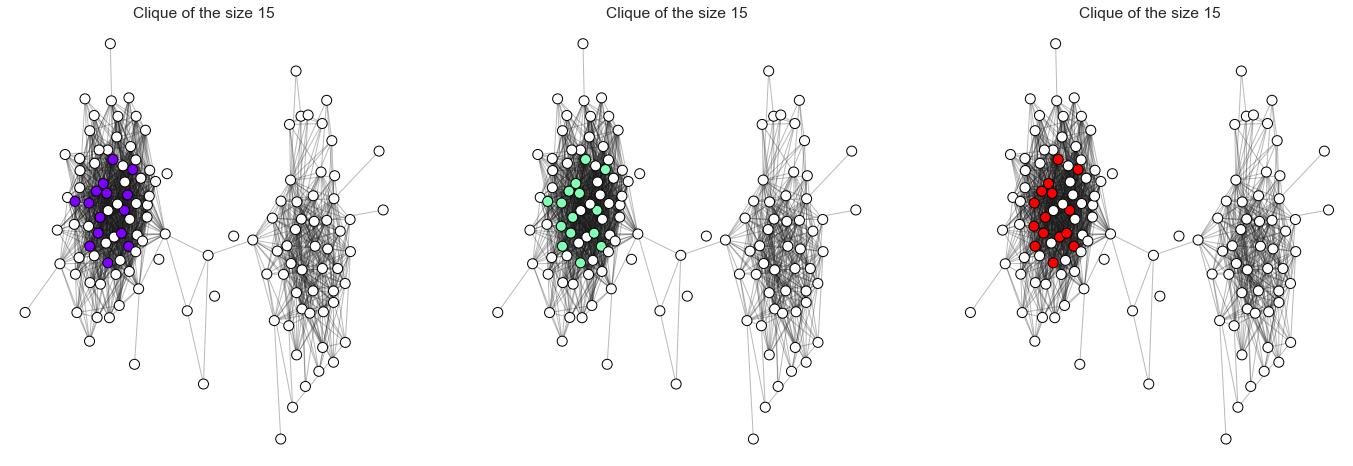

In [165]:
plt.figure(figsize=(24, 8))
pos = nx.kamada_kawai_layout(g)

for i in range(colors.shape[0]):
    
    plt.subplot(1, 3, i+1)
    nodes = nx.draw_networkx_nodes(
        g, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        g,
        pos,
        alpha=0.3,
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

plt.savefig(os.path.join(FIGURES_PREFIX, 'cliques.png'), bbox_inches='tight', dpi=300)    
plt.show()

* There are some groups of university friends
* Few people are present in each clique

## k-cores decomposition

Here we will look at k-cores decomposition.

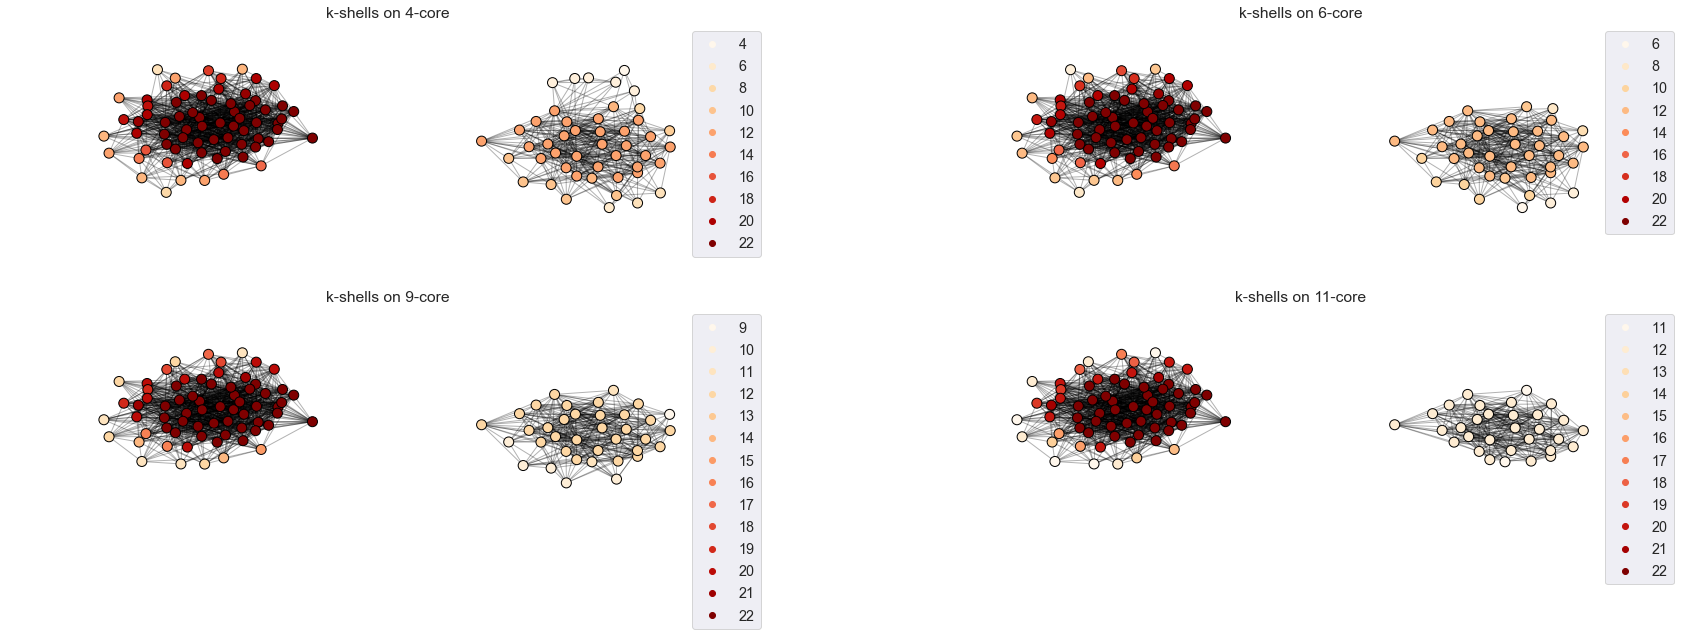

In [166]:
plt.figure(figsize=(30, 20))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)
k_values = [3, 5, 8, 10]

for i, k in enumerate(k_values):
    plt.subplot(4, 2, i+1)
    g_sub = nx.k_core(g, k+1)
    nodes = nx.draw_networkx_nodes(
        g_sub, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=np.array(list(nx.core_number(g_sub).values())), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        g_sub, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(k+1))

plt.savefig(os.path.join(FIGURES_PREFIX, 'k-cores.png'), bbox_inches='tight', dpi=300)  
plt.show()

All plots seem pretty similar: there are two big components and some variation within them.

## Additional attributes

I will add one new attribute, to describe my connection with a person:
* relative
* school
* town
* swimming (I used to participate in swimming competitions at school)
* university
* other

In [167]:
category2idx = {
    'relative': 0,
    'school': 1,
    'town': 2,
    'swimming': 3,
    'university': 4,
    'other': 5,
}

In [168]:
# categories = ['relative', 'school', 'town', 'swimming', 'university', 'other']
# attributes = {}
# for i, values in g.nodes(data=True):
#     print(f"{values['firstname']} {values['lastname']}")
#     category_ind = int(input('Choose the category: '))
#     print(f'You have chosen: {categories[category_ind]}')
#     attributes[i] = categories[category_ind]

# filepath = os.path.join(DATA_PREFIX, 'category.json')
# with open(filepath, 'w') as ouf:
#     json.dump(attributes, ouf)

In [170]:
filepath = os.path.join(DATA_PREFIX, 'category.json')
with open(filepath, 'r') as inf:
    attributes = json.load(inf)

Add new attribute to the graph.

In [171]:
for node in g.nodes(data=True):
    node[1]['category'] = attributes[node[0]]

Count them.

In [172]:
values, counts = np.unique(list(attributes.values()), return_counts=True)
for value, count in zip(values, counts):
    print(f'{value}: {count}')

other: 9
relative: 8
school: 23
swimming: 11
town: 10
university: 72


Visualize it.

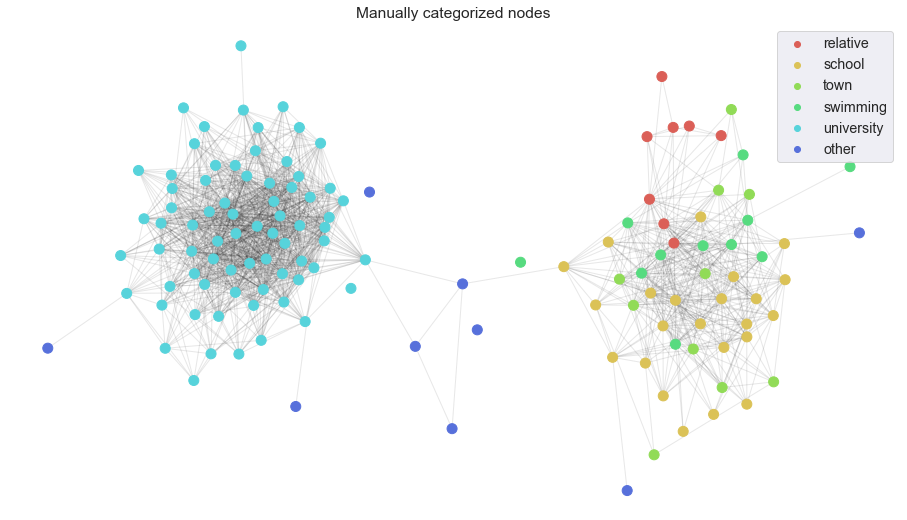

In [181]:
cmap = sns.color_palette('hls', 8)

plt.figure(figsize=(16, 9))
layout = nx.kamada_kawai_layout(g)
node_colors = [cmap[category2idx[x[1]['category']]] for x in g.nodes(data=True)]
nodes = nx.draw_networkx_nodes(g, pos=layout, node_size=100, node_color=node_colors)
nx.draw_networkx_edges(g, pos=layout, alpha=0.1)

# make empty plot with correct color and label for each group
for category, idx in category2idx.items():
    plt.scatter([],[], color=cmap[idx], label=category)

plt.legend()
plt.axis('off')
plt.title('Manually categorized nodes')
plt.savefig(os.path.join(FIGURES_PREFIX, 'manually categorization.png'), bbox_inches='tight', dpi=300)
plt.show()

## Results

Let's try to apply Girvan Newman algorithm with modularity stopping criteria and interpret the results.

In [182]:
def edge_betw_modularity(G, n):
    com_gen = nx.algorithms.community.girvan_newman(G)
    modularities = []
    for i in range(n):
        communities = next(com_gen)
        modularities.append(nx.algorithms.community.modularity(G, communities))
    return np.array(modularities)

In [183]:
n_iterations = 10
modularity = edge_betw_modularity(g, n_iterations)

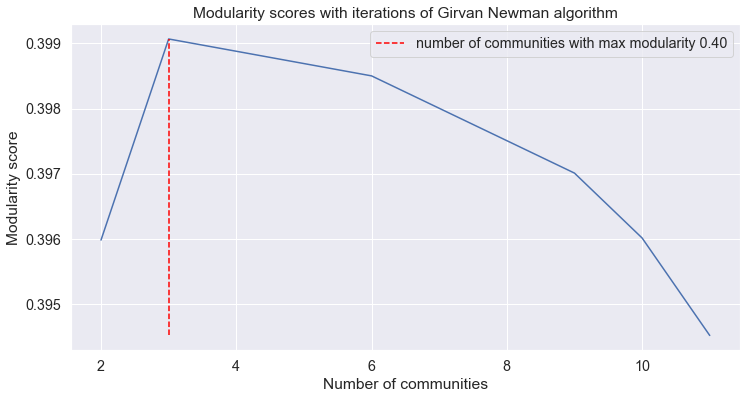

In [184]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    color='red', linestyle='dashed', 
    label=label
)
plt.title('Modularity scores with iterations of Girvan Newman algorithm')
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper right')
plt.savefig(os.path.join(FIGURES_PREFIX, 'modularities girvan newman.png'), bbox_inches='tight', dpi=300)
plt.show()

As we can see, according to the algorithm, the best value is 3. Let's look at the results.

In [185]:
com_gen = nx.algorithms.community.girvan_newman(g)
_ = next(com_gen)
communities = next(com_gen)
node2community = {}
for i, community in enumerate(communities):
    for node in community:
        node2community[node] = i

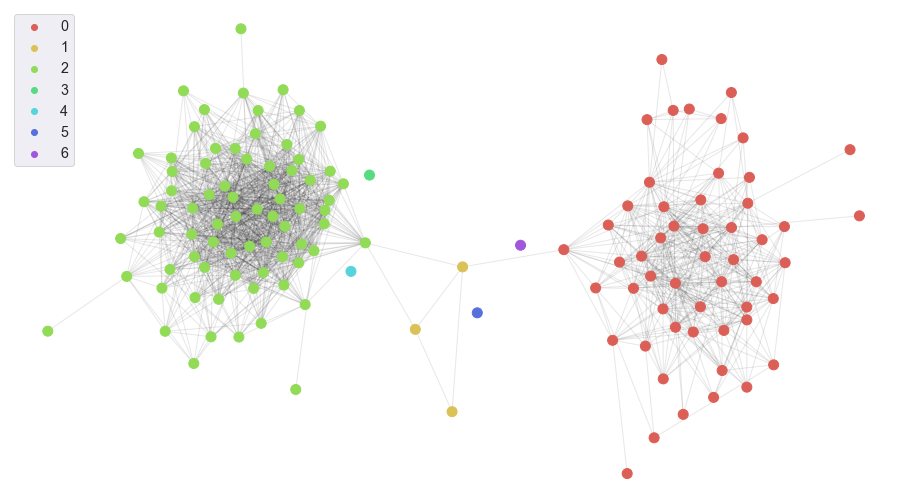

In [191]:
cmap = sns.color_palette('hls', 8)

plt.figure(figsize=(16, 9))
layout = nx.kamada_kawai_layout(g)
node_colors = [cmap[node2community[x]] for x in g.nodes()]
nodes = nx.draw_networkx_nodes(g, pos=layout, node_size=100, node_color=node_colors)
nx.draw_networkx_edges(g, pos=layout, alpha=0.1)

# make empty plot with correct color and label for each group
for idx in range(len(communities)):
    plt.scatter([],[], color=cmap[idx], label=str(idx))

plt.legend()
plt.axis('off')
plt.savefig(os.path.join(FIGURES_PREFIX, 'community-assign.png'), bbox_inches='tight', dpi=300)
plt.show()

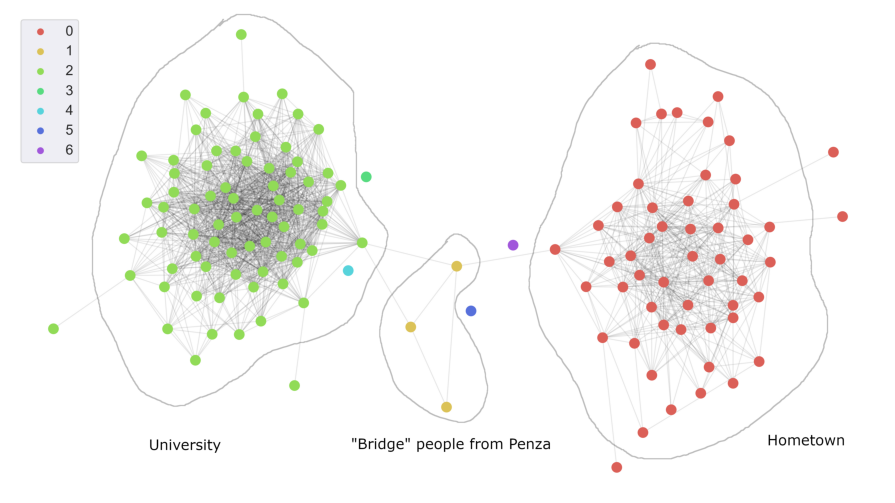

In [192]:
plt.figure(figsize=(16, 9))
plt.axis('off')
image = plt.imread(os.path.join(FIGURES_PREFIX, 'community-assigned.png'))
plt.imshow(image)
plt.show()

We can see communities:
* University
* Relatives/town/school
* Bridge nodes
* Few isolated nodes